In [1]:
from skimage import io,data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import numpy as np
import os
import pandas as pd

1704 2272


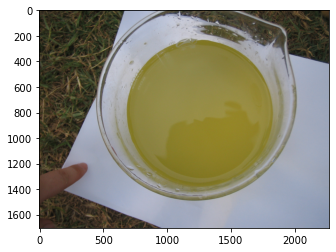

In [2]:
img = mpimg.imread('data/water/data/images/1_1.jpg')#读取一张图片
l,w,t=img.shape                          #提取长，宽，通道数
print(l,w)
plt.imshow(img)

In [3]:
#寻找中心100x100像素点作为水色样本
l_max =img.shape[0]//2+50
l_min=img.shape[0]//2-50
w_max =img.shape[1]//2+50
w_min =img.shape[1]//2-50

## 颜色矩特征提取

In [4]:
#计算颜色矩特征vect
def img2vector(filename):
    vect=np.zeros((1,9))
    fr=mpimg.imread(filename)
    water=fr[l_min:l_max,w_min:w_max,:].reshape(1,100*100,3)
    for i in range(3):
        this = water[:,:,i]/255
        vect[0,i]=np.mean(this)
        vect[0,3+i]=np.sqrt(np.mean(np.square(this-vect[0,i])))
        vect[0,6+i]=np.cbrt(np.mean(np.power(this-vect[0,i], 3)))
    return vect 

In [5]:
datafile=os.listdir('data/water/data/images')#读取目录下文件列表
m=len(datafile)                   #计算文件数目
labels=np.zeros((1,m))
train=np.zeros((1,m))
trainingMat=np.zeros((m,9))

for i in range(m):
    filenamestr=datafile[i]      #获取当前文件名
    filestr=filenamestr.split('.')[0]  #按照.划分，取前一部分
    classnumstr=int(filestr.split('_')[0])#按照_划分，后一部分为该类图片中的编号
    picture_num = int(filestr.split('_')[1])
    labels[0,i]=classnumstr               #图片标签
    train[0,i]=picture_num
    trainingMat[i,:]=img2vector('data/water/data/images/%s' % filenamestr)
    #构成数组

In [6]:
data=np.concatenate((labels.T,train.T,trainingMat),axis=1)#连接数组
data=pd.DataFrame(data,columns=['类别','序号','R通道一阶矩','G通道一阶矩','B通道一阶矩','R通道二阶矩','G通道二阶矩','B通道二阶矩','R通道三阶矩','G通道三阶矩','B通道三阶矩'])
data.to_csv('data/water/data/moment2.csv',encoding = 'utf_8_sig',index=None)#保存文件

## 模型构建

In [4]:
import pandas as pd

inputfile = 'data/water/data/moment2.csv' #数据文件
data = pd.read_csv(inputfile, encoding = 'utf_8_sig') 
data = data.iloc[:,:].values #DataFrame转换成数组


from numpy.random import shuffle 
shuffle(data) #打乱数据

data_train = data[:int(0.8*len(data)), :] #划分训练集 测试集
data_test = data[int(0.8*len(data)):, :]
#构造特征和标签
x_train = data_train[:, 2:]*30
y_train = data_train[:, 0].astype(int)
x_test = data_test[:, 2:]*30
y_test = data_test[:, 0].astype(int)

#构建、训练模型
from sklearn import svm
model = svm.SVC(kernel='rbf')
model.fit(x_train, y_train)

162
41


SVC()

## 模型评估

In [8]:
#准确度
print('Score：',model.score(x_test,y_test))

#混淆矩阵
import sklearn.metrics

sklearn.metrics.confusion_matrix(y_test,model.predict(x_test), labels=[1,2,3,4,5])

Score： 0.6097560975609756


array([[ 5,  2,  3,  0,  0],
       [ 1,  5,  0,  0,  0],
       [ 1,  0, 15,  0,  0],
       [ 0,  0,  6,  0,  0],
       [ 0,  1,  2,  0,  0]], dtype=int64)

## 模型超参数优化

In [16]:
def svm_cross_validation(train_x, train_y):    
    from sklearn.model_selection import GridSearchCV  
    from sklearn.svm import SVC
    model = SVC(kernel='rbf')    
    param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 5, 10, 20,100], 'gamma': [0.01, 0.001, 0.0001]}    
    grid_search = GridSearchCV(model, param_grid, n_jobs = 8, verbose=1)    
    grid_search.fit(train_x, train_y)    
    best_parameters = grid_search.best_estimator_.get_params()  
    model = SVC(kernel='rbf', C=best_parameters['C'], gamma=best_parameters['gamma'])    
    model.fit(train_x, train_y)
    return model
model = svm_cross_validation(x_train, y_train)
model.score(x_test,y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\Admin\.conda\envs\MLC_2022\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


0.7560975609756098